In [1]:
from awips.dataaccess import DataAccessLayer
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime
import geopandas
import logging
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors

%matplotlib inline
import numpy as np
import os
import pandas as pd
import requests
import shapefile
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


In [2]:
cat_plot_colors = {"TSTM": 'palegreen',
                   "MRGL": 'green',
                   "SLGT": 'yellow',
                   "ENH" : 'goldenrod',
                   "MDT" : 'red',
                   "HIGH": 'magenta'}

In [3]:
idate = pd.to_datetime("20200708T01")
#idate = datetime.datetime.now()

In [4]:
# Got from iowa e m https://mesonet.agron.iastate.edu/request/gis/spc_outlooks.phtml

if idate < pd.to_datetime("20221128"):
    if pd.to_datetime("20220101") <= idate < pd.to_datetime("20221128"):
        gdf = geopandas.read_file("outlooks_202201010000_202211280000")
    elif pd.to_datetime("20180101") <= idate < pd.to_datetime("20210101"):
        gdf = geopandas.read_file("outlooks_201801010000_202101010000")
    else:
        logging.error(f"can't find {idate}")
    column = "THRESHOLD"
    subset = gdf["DAY"].eq(1) & gdf["CATEGORY"].eq("CATEGORICAL") # & gdf["ISSUE"].eq(idate.strftime("%Y%m%d%H%M"))
    gdf = gdf[subset]
else:
    ifile = requests.get("https://www.spc.noaa.gov/products/outlook/day1otlk_cat.nolyr.geojson")
    gdf = geopandas.GeoDataFrame.from_features(ifile.json())
    gdf = gdf.set_crs("epsg:4269")
    column = "LABEL"
gdf = gdf[gdf.ISSUE == idate.strftime("%Y%m%d%H%M")]
gdf.head(10)

,ISSUE,EXPIRE,PRODISS,TYPE,DAY,THRESHOLD,CATEGORY,CYCLE,geometry
34540,202007080100,202007081200,202007080042,C,1,ENH,CATEGORICAL,1,"POLYGON ((-103.57300 48.99100, -101.07900 48.9..."
34541,202007080100,202007081200,202007080042,C,1,SLGT,CATEGORICAL,1,"POLYGON ((-105.60500 49.00900, -103.57300 48.9..."
34542,202007080100,202007081200,202007080042,C,1,MRGL,CATEGORICAL,1,"POLYGON ((-103.57300 48.99100, -101.07900 48.9..."
34543,202007080100,202007081200,202007080042,C,1,TSTM,CATEGORICAL,1,"MULTIPOLYGON (((-108.99300 48.99600, -107.3100..."


In [5]:
gdf.explore(legend=True, column=column, categories=["TSTM","MRGL","SLGT","ENH","MDT","HIGH"],
           cmap=colors.ListedColormap(list(cat_plot_colors.values())))

In [6]:
start = pd.to_datetime("20190122T01")
end = pd.to_datetime("20191206T01")
for idate in pd.date_range(start=start, end=end, freq="1D"):
    idate = idate.strftime("%Y%m%d%H%M")
    if gdf[column].eq("HIGH").any():
        logging.info(gdf)
        cat = "TSTM"
        for subtract in ["MRGL", "SLGT", "ENH", "MDT", "HIGH"]:
            logging.info(f"subtracting {subtract}")
            gdf.loc[gdf[column].eq(cat)] = gdf.loc[gdf[column].eq(cat)].overlay(gdf[gdf[column].eq(subtract)],
                                                                                      how="difference").values
            cat = subtract   
        break
            
print(idate)
gdf.explore(legend=True, column=column, categories=["TSTM","MRGL","SLGT","ENH","MDT","HIGH"],
           cmap=colors.ListedColormap(list(cat_plot_colors.values())))


201912060100


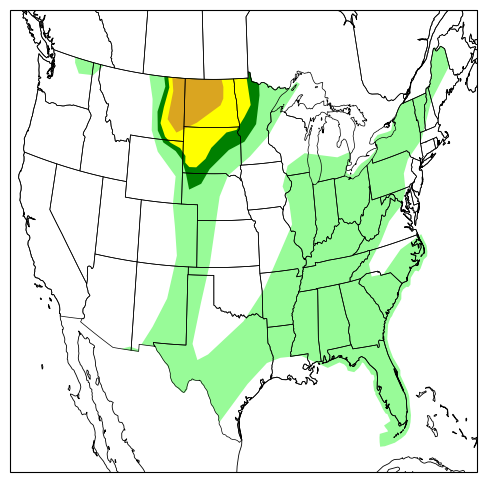

In [15]:
fig = plt.figure(1, figsize=(8,6))
map_crs = ccrs.LambertConformal(central_latitude=35, central_longitude=-100)
ax = plt.subplot(projection=map_crs)
ax.set_extent([-120, -74, 22, 51])
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.6)

if gdf.empty:
    logging.warning(f"no {idate}")
else:
    for key in cat_plot_colors.keys():
        geometries = gdf[gdf[column].eq(key)]
        if len(geometries)>0:
            geometries.plot(ax=ax, color=cat_plot_colors[key], transform=ccrs.PlateCarree(), legend=True)

In [16]:
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
request = DataAccessLayer.newDataRequest()
request.setDatatype("grid")
request.setLocationNames("LAMP2p5")
request.setParameters("PROLGHT2hr")
#request.setLevels("2.0FHAG")

# Take a look at our request
print(request)

DefaultDataRequest(datatype=grid, identifiers={}, parameters=['PROLGHT2hr'], levels=[], locationNames=['LAMP2p5'], envelope=None)


In [17]:
grid_locations = DataAccessLayer.getAvailableLevels(request)
grid_locations.sort()
list(grid_locations)

In [18]:
cycles = DataAccessLayer.getAvailableTimes(request, True)
times = DataAccessLayer.getAvailableTimes(request)
fcstRun = DataAccessLayer.getForecastRun(cycles[-1], times)

# Get the most recent grid data
response = DataAccessLayer.getGridData(request, [fcstRun[0]])

print('Number of available times:', len(times))
print('Number of available forecast runs:', len(fcstRun))

Number of available times: 42
Number of available forecast runs: 14


In [74]:
def make_map(bbox, projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(16, 9),
            subplot_kw=dict(projection=projection))
    ax.set_extent(bbox)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.25)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.25)
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.05)
    ax.add_feature(cfeature.LAKES.with_scale('50m'), edgecolor='k', linewidth=0.25, facecolor='k', alpha=0.05)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = gl.right_labels = False
    #gl.xformatter = LONGITUDE_FORMATTER
    #gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

In [20]:
grid = response[0]
data = grid.getRawData()
lons, lats = grid.getLatLonCoords()
bbox = [lons.min(), lons.max(), lats.min(), lats.max()]

In [21]:
grid.getUnit()

'%'

In [22]:
data[data == -999999] = np.nan
data.min()
np.nanmin(data)

0.0

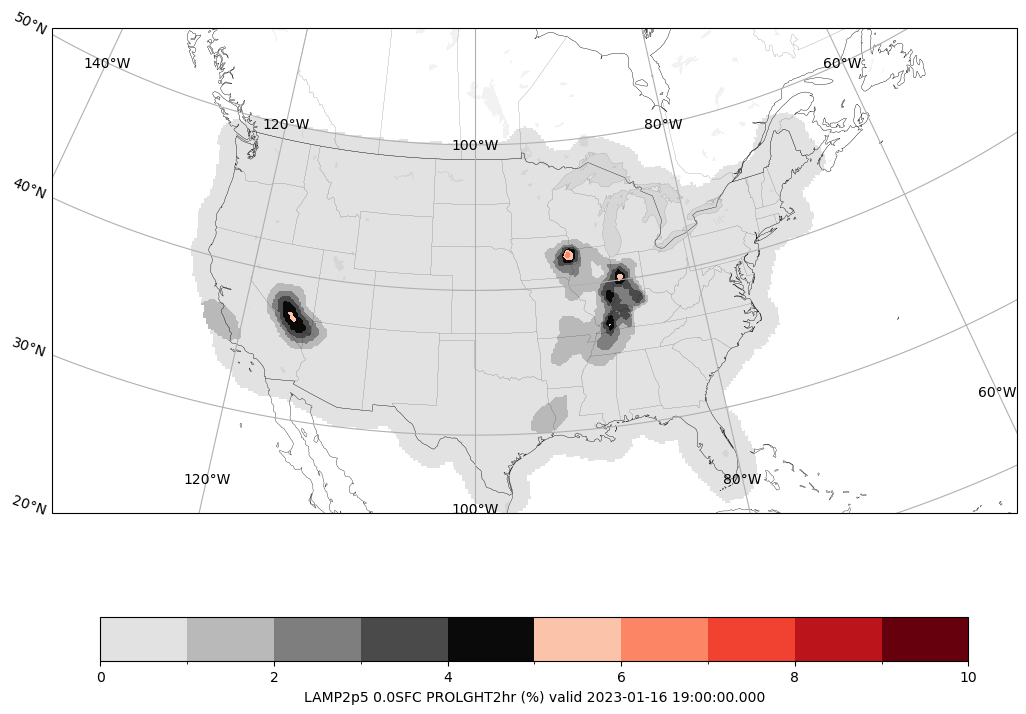

In [75]:
cmap = plt.get_cmap('rainbow')
from fieldinfo import readNCLcm
from matplotlib.colors import ListedColormap, BoundaryNorm
test = readNCLcm('MPL_Greys')[25::] + [[1,1,1]] + readNCLcm('MPL_Reds')[10::]
cmap = ListedColormap(test)
norm = BoundaryNorm(np.arange(0,11,1), ncolors=cmap.N, clip=True)

fig, ax = make_map(bbox=bbox, projection = map_crs)
cs = ax.pcolormesh(lons, lats, data, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar = fig.colorbar(cs, shrink=0.7, orientation='horizontal')
cbar.set_label(grid.getLocationName() +" "+ grid.getLevel() + " " \
               + grid.getParameter() + " (" + grid.getUnit() + ") " \
               + "valid " + str(grid.getDataTime().getRefTime()))

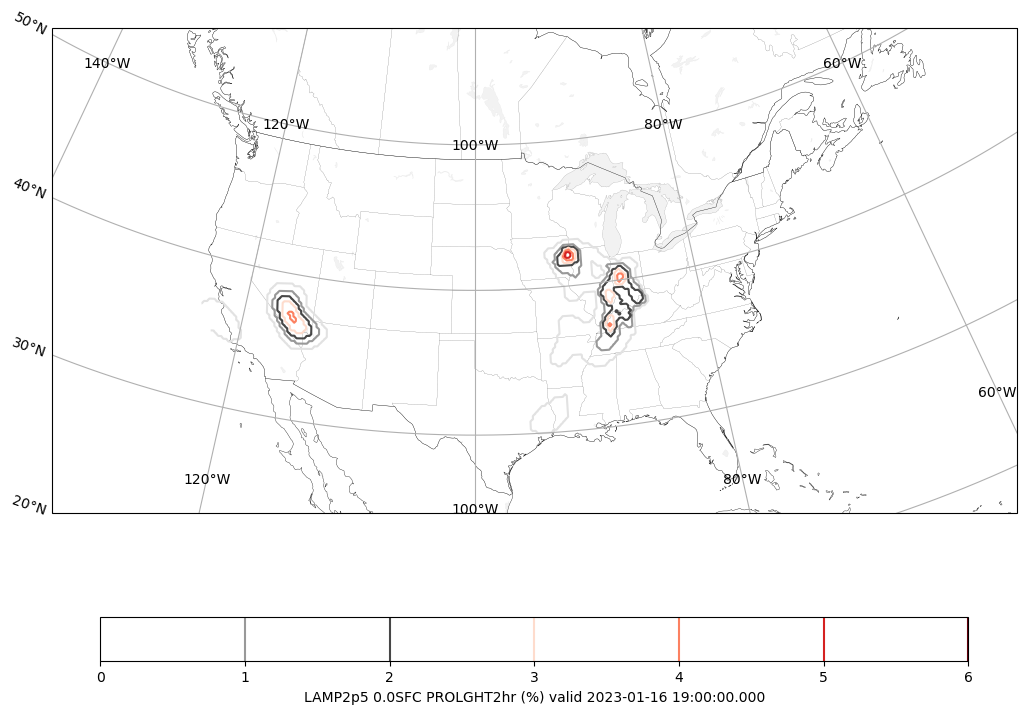

In [76]:
fig2, ax2 = make_map(bbox=bbox, projection=map_crs)
cs2 = ax2.contour(lons, lats, data, 80, cmap=cmap, levels=6,
                  transform=ccrs.PlateCarree(),
                  vmin=np.nanmin(data), vmax=np.nanmax(data))
cbar2 = fig2.colorbar(cs2, shrink=0.7, orientation='horizontal')
cbar2.set_label(grid.getLocationName() +" "+ grid.getLevel() + " " \
               + grid.getParameter() + " (" + grid.getUnit() + ") " \
               + "valid " + str(grid.getDataTime().getRefTime()))

In [30]:
from ml_functions import configs_match, get_argparser, get_features, savedmodel_default, brier_skill_score, grab_predictors
from sklearn.model_selection import KFold
from tensorflow.keras.models import load_model
import yaml

2023-01-16 13:27:21.335587: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-16 13:27:22.727341: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-16 13:27:35.765195: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glade/u/apps/dav/opt/cuda/11.4.0/extras/CUPTI/lib64:/glade/u/apps/dav/opt/cuda/11.4.0/

In [31]:
idate = pd.to_datetime(idate).round("D")
idate

Timestamp('2019-12-06 00:00:00')

In [37]:
parser = get_argparser()
args = parser.parse_args(args="--model HRRR --batchsize 1024 --neurons 1024 --optim adam --glm "
                         "--trainstart 19700101 --trainend 20201202 --teststart 20201202T12 "
                         "--testend 20220101 --epochs 30 --learning 0.001 --kfold 5".split())
df = grab_predictors(args, idate)

In [38]:
args

Namespace(batchnorm=False, batchsize=1024, clobber=False, debug=False, dropout=0.0, epochs=30, fhr=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48], fits=None, flash=10, folds=None, glm=True, kfold=5, ifile=None, learning_rate=0.001, model='HRRR', neurons=[1024], nfits=5, nprocs=0, optimizer='adam', reg_penalty=0.01, rptdist=40, savedmodel=None, seed=None, trainend=Timestamp('2020-12-02 00:00:00'), trainstart=Timestamp('1970-01-01 00:00:00'), testend=Timestamp('2022-01-01 00:00:00'), teststart=Timestamp('2020-12-02 12:00:00'), suite='default', twin=2)

In [ ]:
features = get_features(args)
df = df[features]
features = df
features

In [43]:
y_preds = pd.DataFrame()
for ifold in range(args.kfold):
    for thisfit in range(args.nfits):
        savedmodel_thisfitfold = f"nn/HRRR.default.10flash.rpt_40km_2hr.1024n.ep10.f01-f48.bs1024.Adam.L20.01.lr0.001.dr0.0_{thisfit}/{args.kfold}fold{ifold}"
        yl = yaml.load(open(
            os.path.join(savedmodel_thisfitfold, "config.yaml"), "r"),
            Loader=yaml.Loader)
        labels = yl["labels"]
        # delete labels so we can make DataFrame from rest of dictionary.
        del (yl["labels"])
        del (yl["args"])
        # scaling values DataFrame as from .describe()
        sv = pd.DataFrame(yl).set_index("columns").T
        if sv.columns.size != features.columns.size:
            logging.error(
                f"size of yaml and features columns differ {sv.columns} {features.columns}"
            )
        if not all(sv.columns == features.columns):
            logging.info(f"reordering columns")
            features = features.reindex(columns=sv.columns)
        assert all(
            sv.columns == features.columns
        ), f"columns {features.columns} don't match when model was trained {sv.columns}"

        logging.info(f"loading {savedmodel_thisfitfold}")
        model = load_model(
            savedmodel_thisfitfold,
            custom_objects=dict(brier_skill_score=brier_skill_score))
        norm_features = (features - sv.loc["mean"]) / sv.loc["std"]
        # Grab numpy array of predictions.
        Y = model.predict(norm_features.to_numpy(dtype='float32'))
        Y = pd.DataFrame(Y, columns=labels, index=features.index)
        # prepend "fit" level to multilevel DataFrame
        Y = pd.concat([Y], keys=[thisfit], names=["fit"])
        # prepend "fold" level
        Y = pd.concat([Y], keys=[ifold], names=["fold"])
        # concatenate this fit/fold to the y_preds DataFrame
        y_preds = pd.concat([y_preds, Y], axis="index")

In [45]:
# I may have overlapping valid_times from different init_times like fhr=1 from today and fhr=25 from previous day
# average probability over all nfits initialized at initialization_time and valid at valid_time
ensmean = y_preds.groupby(level=[
    "valid_time", "y", "x"
]).mean()
assert "fit" not in ensmean.index.names, "fit should not be a MultiIndex level of ensmean, the average probability over nfits."

In [47]:
ensmean

sighail_40km_2hr  sigwind_40km_2hr  \
valid_time          y  x                                        
2019-12-06 01:00:00 21 33      8.219051e-08      1.036491e-06   
                       34      7.320165e-08      1.132466e-06   
                       35      7.093785e-08      1.274081e-06   
                       36      6.519024e-08      1.149106e-06   
                    22 29      8.012109e-08      6.247838e-07   
...                                     ...               ...   
2019-12-08 00:00:00 79 41      7.295719e-09      2.621047e-07   
                       42      5.803491e-09      2.276895e-07   
                       43      4.659857e-09      1.958752e-07   
                       44      4.196698e-09      1.941495e-07   
                    80 41      7.738004e-09      2.631531e-07   

                           hailone_40km_2hr  wind_40km_2hr  torn_40km_2hr  \
valid_time          y  x                                                    
2019-12-06 01:00:00 21 33      3.964754e-06       0.000051   3.438091e-06   
                       34      3.913606e-06       0.000054   3.682512e-06   
                       35      4.125389e-06       0.000059   3.954042e-06   
                       36      3.761188e-06       0.000053   3.589748e-06   
                    22 29      3.096705e-06       0.000031   2.048401e-06   
...                                     ...            ...            ...   
2019-12-08 00:00:00 79 41      6.613939e-07       0.000012   7.863177e-07   
                       42      5.784710e-07       0.000010   6.744179e-07   
                       43      4.813075e-07       0.000009   5.910720e-07   
                       44      4.453637e-07       0.000009   5.993073e-07   
                    80 41      6.779563e-07       0.000012   7.821404e-07   

                           any_40km_2hr  flashes_40km_2hr  
valid_time          y  x                                   
2019-12-06 01:00:00 21 33      0.000058          0.000407  
                       34      0.000060          0.000409  
                       35      0.000065          0.000441  
                       36      0.000059          0.000380  
                    22 29      0.000038          0.000272  
...                                 ...               ...  
2019-12-08 00:00:00 79 41      0.000013          0.000055  
                       42      0.000011          0.000047  
                       43      0.000009          0.000038  
                       44      0.000009          0.000035  
                    80 41      0.000013          0.000057  

[62784 rows x 7 columns]

<GeoAxesSubplot: title={'center': '20191206T01 to 20191208T00'}, xlabel='lon', ylabel='lat'>

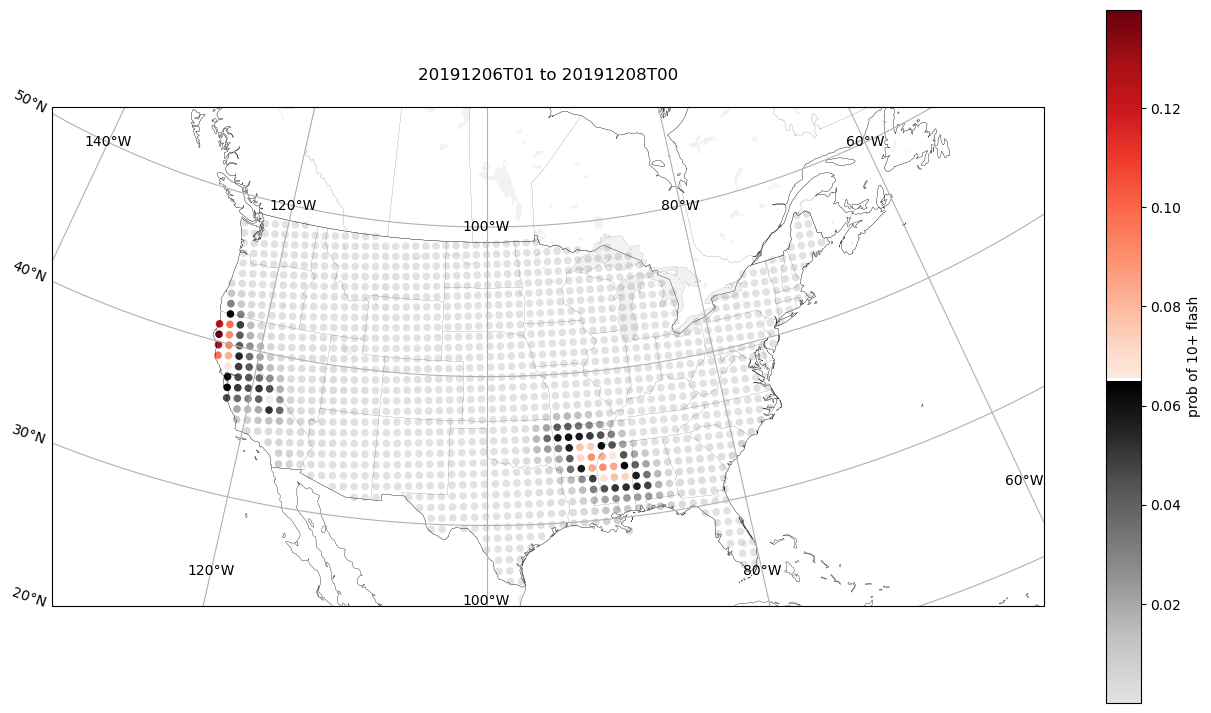

In [77]:
fig, ax = make_map(bbox=bbox, projection=map_crs)
features["prob of 10+ flash"] = ensmean["flashes_40km_2hr"]
valid_times = ensmean.index.get_level_values("valid_time")
title=f'{valid_times.min().strftime("%Y%m%dT%H")} to {valid_times.max().strftime("%Y%m%dT%H")}'
features.groupby(["y","x"]).mean()[["lat","lon","prob of 10+ flash"]].plot(ax=ax, title=title, cmap=cmap,
                                                                           kind="scatter",x="lon",y="lat",c="prob of 10+ flash",
                                                                          transform=ccrs.PlateCarree())

In [ ]:
pd.concat([features[["lat","lon"]], Y.groupby(["y","x"]).mean()])